<a href="https://colab.research.google.com/github/GeneSUN/time-series-analysis-toolkit/blob/main/Validation_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
%cd ../..

/


In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import TimeSeriesSplit

# Utility Functions

In [13]:
#@title plot_temporal_cv_splits
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_temporal_cv_splits(cv, a):
    datasets = {}
    sns.set_style("whitegrid")
    sns.set_context("talk")

    w = 0.6
    fig, ax = plt.subplots(figsize=(8, cv.get_n_splits() * 1))

    for split_id, (trn_idx, val_idx) in enumerate(cv.split(a)):
        datasets[f"split_{split_id}"] = {
            "train": a[trn_idx],
            "validation": a[val_idx]
        }

        # train block
        ax.barh(split_id, trn_idx[-1] - trn_idx[0] + 1, left=trn_idx[0],
                height=w, color=sns.color_palette("deep")[0], edgecolor="black", alpha=0.9,
                label="Train" if split_id == 0 else "")

        # validation block
        ax.barh(split_id, val_idx[-1] - val_idx[0] + 1, left=val_idx[0],
                height=w, color=sns.color_palette("deep")[3], edgecolor="black", alpha=0.9,
                label="Validation" if split_id == 0 else "")

    ax.set_xlim(0, len(a))
    ax.set_ylim(-0.5, cv.get_n_splits() - 0.5)
    ax.set_yticks(range(cv.get_n_splits()))
    ax.set_yticklabels([f"split_{i}" for i in range(cv.get_n_splits())])
    ax.invert_yaxis()
    ax.set_xlabel("Index", fontsize=12)
    ax.set_title("Temporal CV Splits", fontsize=14, weight="bold")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()
    return datasets



In [14]:
#@title plot_cv_splits
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
from operator import itemgetter

def plot_cv_splits(cv, a):

    datasets = {}
    sns.set_style("whitegrid")
    sns.set_context("talk")

    w = 0.6
    fig, ax = plt.subplots(figsize=(12, cv.get_n_splits() * 1.2))
    _range = np.arange(len(a))

    for split_id, (trn_idx, val_idx) in enumerate(cv.split(a)):
        # store train/validation data
        datasets[f"split_{split_id}"] = {
            "train": a[trn_idx],
            "validation": a[val_idx]
        }

        # masks
        val_mask = np.isin(_range, val_idx)
        trn_mask = np.isin(_range, trn_idx)
        gap_mask = ~(trn_mask | val_mask)  # indices in neither

        # restrict gap detection to within span of this split
        split_min = min(np.min(trn_idx), np.min(val_idx))
        split_max = max(np.max(trn_idx), np.max(val_idx))
        gap_idx = np.where(gap_mask)[0]
        gap_idx = gap_idx[(gap_idx >= split_min) & (gap_idx <= split_max)]

        # train blocks (may be multiple contiguous segments)
        for _, g in groupby(enumerate(np.where(trn_mask)[0]), lambda i_x: i_x[0] - i_x[1]):
            block = list(map(itemgetter(1), g))
            ax.barh(split_id, len(block), left=block[0],
                    height=w, color=sns.color_palette("deep")[0],
                    edgecolor="black", alpha=0.9,
                    label="Train" if split_id == 0 else "")

        # validation blocks
        for _, g in groupby(enumerate(np.where(val_mask)[0]), lambda i_x: i_x[0] - i_x[1]):
            block = list(map(itemgetter(1), g))
            ax.barh(split_id, len(block), left=block[0],
                    height=w, color=sns.color_palette("deep")[3],
                    edgecolor="black", alpha=0.9,
                    label="Validation" if split_id == 0 else "")

        # gap blocks (only internal)
        for _, g in groupby(enumerate(gap_idx), lambda i_x: i_x[0] - i_x[1]):
            block = list(map(itemgetter(1), g))
            ax.barh(split_id, len(block), left=block[0],
                    height=w, color="gray",
                    edgecolor="black", alpha=0.7,
                    label="Gap" if split_id == 0 else "")

    # formatting
    ax.set_xlim(0, len(a))
    ax.set_ylim(-0.5, cv.get_n_splits() - 0.5)
    ax.set_yticks(range(cv.get_n_splits()))
    ax.set_yticklabels([f"split_{i}" for i in range(cv.get_n_splits())])
    ax.invert_yaxis()
    ax.set_xlabel("Index", fontsize=12)
    ax.set_title("Cross-Validation Splits", fontsize=14, weight="bold")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

    plt.tight_layout()
    plt.show()
    return datasets


# Validation Strategies

In [15]:
N = 50
a = np.arange(N)

## 1.Repeated Holdout with no Overlap (Expanding Window)

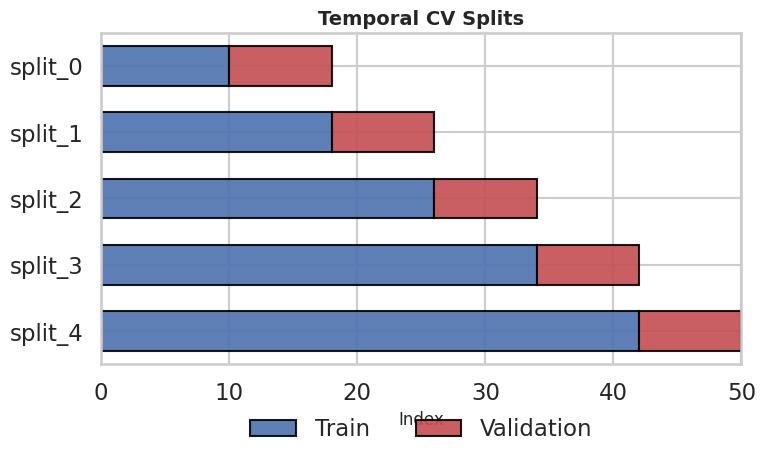

In [16]:
cv = TimeSeriesSplit(n_splits=5, gap = 0)
datasets = plot_temporal_cv_splits(cv, a)


In [17]:

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

,train,validation
split_0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17]"
split_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[18, 19, 20, 21, 22, 23, 24, 25]"
split_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26, 27, 28, 29, 30, 31, 32, 33]"
split_3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[34, 35, 36, 37, 38, 39, 40, 41]"
split_4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[42, 43, 44, 45, 46, 47, 48, 49]"


## 2.Repeated Holdout with no Overlap (Rolling Window)

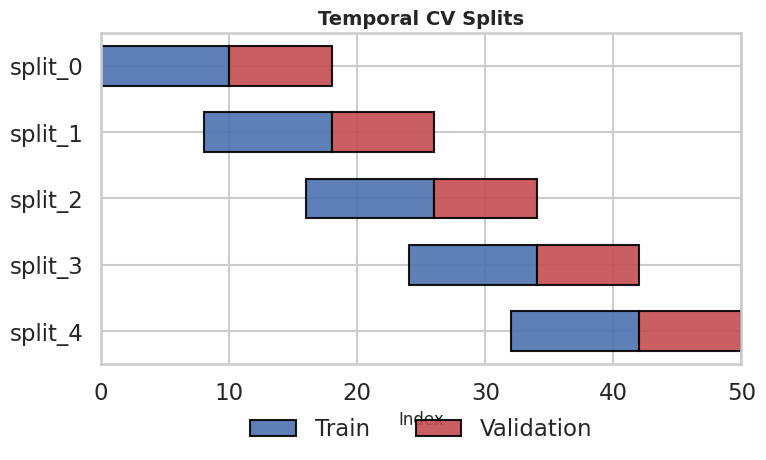

,train,validation
split_0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[10, 11, 12, 13, 14, 15, 16, 17]"
split_1,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17]","[18, 19, 20, 21, 22, 23, 24, 25]"
split_2,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25]","[26, 27, 28, 29, 30, 31, 32, 33]"
split_3,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33]","[34, 35, 36, 37, 38, 39, 40, 41]"
split_4,"[32, 33, 34, 35, 36, 37, 38, 39, 40, 41]","[42, 43, 44, 45, 46, 47, 48, 49]"


In [18]:
cv = TimeSeriesSplit(n_splits=5, max_train_size=10)
datasets = plot_temporal_cv_splits(cv, a)


datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

## 3.Repeated Holdout with no Overlap with Gaps (Expanding Window)

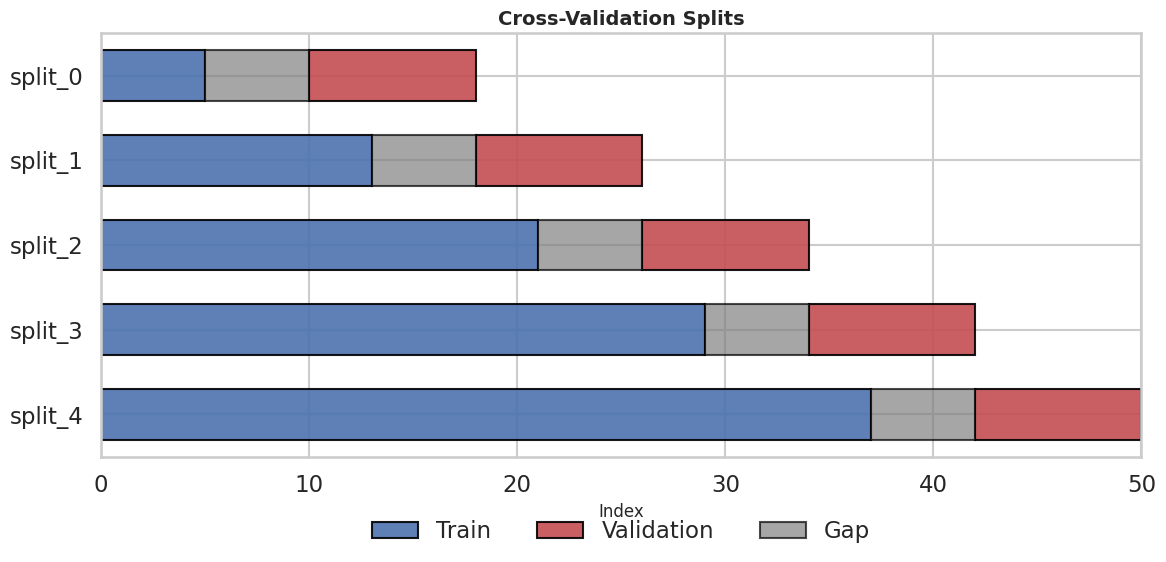

,train,validation
split_0,"[0, 1, 2, 3, 4]","[10, 11, 12, 13, 14, 15, 16, 17]"
split_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[18, 19, 20, 21, 22, 23, 24, 25]"
split_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[26, 27, 28, 29, 30, 31, 32, 33]"
split_3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[34, 35, 36, 37, 38, 39, 40, 41]"
split_4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[42, 43, 44, 45, 46, 47, 48, 49]"


In [19]:
cv = TimeSeriesSplit(n_splits=5, gap=5)
datasets = plot_cv_splits(cv, a)
datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

## 4.Repeated Holdout with no Overlap with Gaps (Rolling Window)

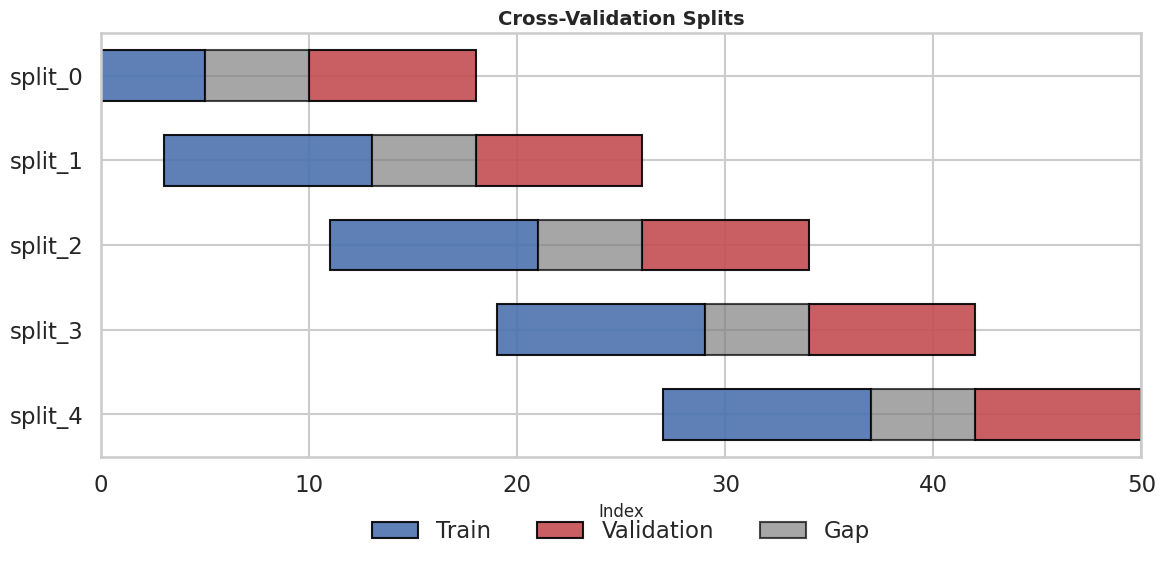

,train,validation
split_0,"[0, 1, 2, 3, 4]","[10, 11, 12, 13, 14, 15, 16, 17]"
split_1,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[18, 19, 20, 21, 22, 23, 24, 25]"
split_2,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20]","[26, 27, 28, 29, 30, 31, 32, 33]"
split_3,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28]","[34, 35, 36, 37, 38, 39, 40, 41]"
split_4,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36]","[42, 43, 44, 45, 46, 47, 48, 49]"


In [20]:
cv = TimeSeriesSplit(n_splits=5, max_train_size=10, gap=5)
datasets = plot_cv_splits(cv, a)


datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

## 5.Blocked Cross-Validation

In [21]:
from sklearn.model_selection import KFold

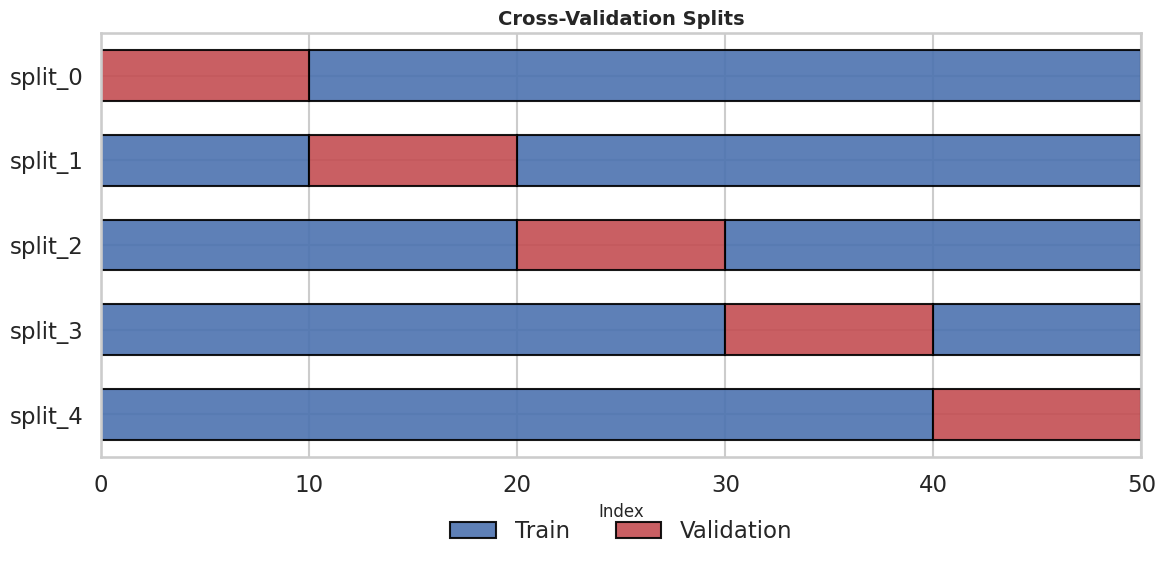

,train,validation
split_0,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
split_1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23,...","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"
split_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]"
split_3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]"
split_4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]"


In [22]:
cv = KFold(n_splits=5, shuffle=False) #blocked CV

datasets = plot_cv_splits(cv, a)

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)

## 6.Blocked Cross-Validation with Gaps

In [23]:
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils.validation import _num_samples, indexable

In [24]:
class KFoldGap(_BaseKFold):
    def __init__(self, n_splits=5, gap=0, *, random_state=None):
        self.gap = gap
        super().__init__(n_splits=n_splits, shuffle=False, random_state=random_state)

    def _iter_test_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        indices = np.arange(n_samples)
        n_splits = self.n_splits
        fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=int)
        fold_sizes[: n_samples % n_splits] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            yield start,stop
            current = stop

    def split(self, X, y=None, groups=None):
        X, y, groups = indexable(X, y, groups)
        indices = np.arange(_num_samples(X))
        for test_start, test_stop in self._iter_test_indices(X, y, groups):
            test_index = indices[test_start:test_stop]
            inv_train_index = indices[max(test_start-self.gap,0):test_stop+self.gap]
            test_mask = np.zeros(_num_samples(X), dtype=bool)
            test_mask[inv_train_index] = True
            train_index = indices[np.logical_not(test_mask)]
            yield train_index, test_index

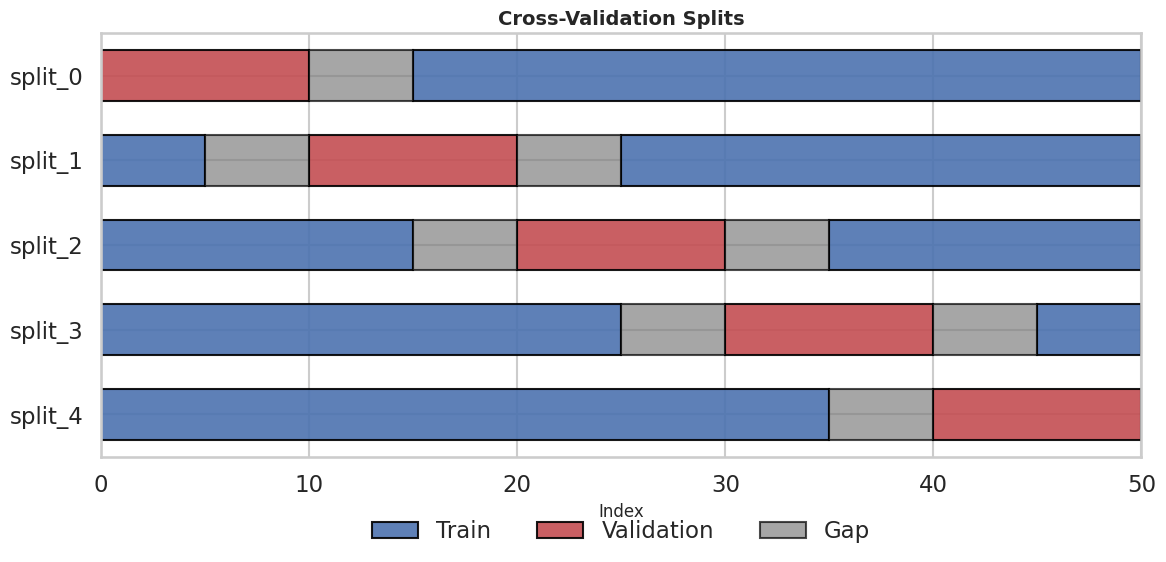

,train,validation
split_0,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
split_1,"[0, 1, 2, 3, 4, 25, 26, 27, 28, 29, 30, 31, 32...","[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"
split_2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]"
split_3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]"
split_4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]"


In [26]:
cv = KFoldGap(n_splits=5, gap=5) #blocked CV
datasets = plot_cv_splits(cv, a)

datasets_df = pd.DataFrame(datasets)
datasets_df_pivoted = datasets_df.T
display(datasets_df_pivoted)